In [2]:
import pandas as pd

# Load Data
    First, load the data to take a look of the original data.
    We found that there is also `Cancelled` flight by column `delay_time` which was expected to be `float` or `int`.
    Change `Cancelled` value to `9999` to make `delay_time` able to convert to `float`.
    So for the analysis part we will analyze `on_time`, `delayed` and `cancelled` flights.

In [3]:
df = pd.read_csv("flight_delays_data.csv", parse_dates=[8])
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899114 entries, 0 to 899113
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   flight_id    899114 non-null  int64         
 1   flight_no    899114 non-null  object        
 2   Week         899114 non-null  int64         
 3   Departure    899114 non-null  object        
 4   Arrival      899114 non-null  object        
 5   Airline      897400 non-null  object        
 6   std_hour     899114 non-null  int64         
 7   delay_time   899114 non-null  object        
 8   flight_date  899114 non-null  datetime64[ns]
 9   is_claim     899114 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 68.6+ MB


In [5]:
df.delay_time.unique()

array(['0.4', '0.5', '0.0', '0.1', '0.2', '0.3', '0.9', '0.8', '-0.1',
       '1.0', '0.7', '-0.2', '2.4', '0.6', '1.2', '1.4', '1.5',
       'Cancelled', '-0.3', '2.3', '1.7', '3.7', '1.1', '3.8', '1.8',
       '5.4', '1.3', '-0.4', '2.2', '2.6', '16.2', '1.9', '1.6', '5.1',
       '4.8', '-0.7', '3.2', '2.1', '-9.3', '-8.0', '15.8', '2.0', '-7.0',
       '16.0', '3.9', '6.5', '3.5', '3.0', '-3.7', '5.3', '5.0', '2.7',
       '3.4', '5.7', '4.0', '-0.5', '2.8', '3.3', '-7.2', '-9.9', '3.6',
       '3.1', '7.5', '-8.2', '2.9', '2.5', '8.6', '6.8', '5.9', '4.7',
       '-13.9', '5.8', '12.8', '-8.1', '11.0', '-12.4', '10.6', '22.7',
       '18.3', '9.1', '-7.6', '7.8', '-6.6', '15.9', '16.1', '4.1',
       '12.0', '4.3', '4.4', '8.9', '6.0', '6.9', '7.9', '4.5', '-7.9',
       '17.0', '7.4', '7.1', '5.5', '6.4', '-7.7', '12.2', '-6.2', '11.9',
       '23.9', '4.9', '-10.8', '4.6', '9.8', '9.7', '16.8', '-1.6',
       '-12.7', '6.1', '8.7', '6.2', '12.6', '9.9', '17.6', '-7.8',
       '-

Then, label encode the categorical data and separate `flight_date` into three columns `flight_year`, `flight_month`, `flight_day`
I added a binary category column `label` from `is_claim`.

In [6]:
from sklearn import preprocessing

In [7]:
le = preprocessing.LabelEncoder()
df["Arrival_enc"] = le.fit_transform(df["Arrival"])
df["Airline_enc"] = le.fit_transform(df["Airline"])

In [8]:
df["flight_year"] = df["flight_date"].apply(lambda x: x.year)
df["flight_month"] = df["flight_date"].apply(lambda x: x.month)
df["flight_day"] = df["flight_date"].apply(lambda x: x.day)

df["delay_time"] = df["delay_time"].apply(lambda x: 9999 if x == "Cancelled" else float(x))

df["label"] = df["is_claim"].apply(lambda x: True if x != 0 else False)

In [9]:
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,73,110,2016,7,1,False
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,140,26,2015,4,23,False
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,94,85,2014,4,8,False


In [10]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label
flight_id,1.000000,-0.000409,-0.000416,0.000650,-0.000041,0.001616,-0.001176,0.000569,-0.000473,0.000615,-0.000041
Week,-0.000409,1.000000,-0.000176,0.000285,-0.014874,-0.000057,0.001449,-0.428666,0.996447,0.096420,-0.014874
std_hour,-0.000416,-0.000176,1.000000,0.001303,-0.000481,-0.029533,0.019807,-0.003853,-0.000176,-0.000377,-0.000481
delay_time,0.000650,0.000285,0.001303,1.000000,0.801306,0.000751,0.023776,0.015390,0.001405,-0.010365,0.801306
is_claim,-0.000041,-0.014874,-0.000481,0.801306,1.000000,0.011480,0.017709,0.030985,-0.014816,0.001088,1.000000
Arrival_enc,0.001616,-0.000057,-0.029533,0.000751,0.011480,1.000000,-0.042319,-0.027319,-0.000035,0.000072,0.011480
Airline_enc,-0.001176,0.001449,0.019807,0.023776,0.017709,-0.042319,1.000000,-0.004888,0.001485,-0.000596,0.017709
flight_year,0.000569,-0.428666,-0.003853,0.015390,0.030985,-0.027319,-0.004888,1.000000,-0.431298,-0.003407,0.030985
flight_month,-0.000473,0.996447,-0.000176,0.001405,-0.014816,-0.000035,0.001485,-0.431298,1.000000,0.014613,-0.014816
flight_day,0.000615,0.096420,-0.000377,-0.010365,0.001088,0.000072,-0.000596,-0.003407,0.014613,1.000000,0.001088


# Flights EDA
Here we will focus on three columns `flight_date`, `Airline`, `Arrival`, aiming to generate some statistics feature.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
dataframe_dict = {
    "On-time": df[df.delay_time < 3],
    "Delayed": df[(df.delay_time >= 3)&(df.delay_time != 9999)],
    "Cancelled": df[df.delay_time == 9999]
}

In [13]:
def value_count_plot(item: tuple, value_columns: list, axis_index: int):
    (key, dataframe) = item
    default_col = ['delay_time']
    columns = default_col + value_columns
    df = dataframe[columns].groupby(value_columns).count()
    df.plot(ax=ax[axis_index])

    ax[axis_index].legend([key])
    for idx, row in df.reset_index().sort_values(by=default_col, ascending=False).head().iterrows():
        if len(value_columns) == 1:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns].values, y=row.loc[default_col].values), (idx+1, row.loc[default_col].values))
        else:
            ax[axis_index].annotate("({x}, {y})".format(x=row.loc[value_columns[0]], y=row.loc[value_columns[1]]), (idx-1, row.loc[default_col].values))


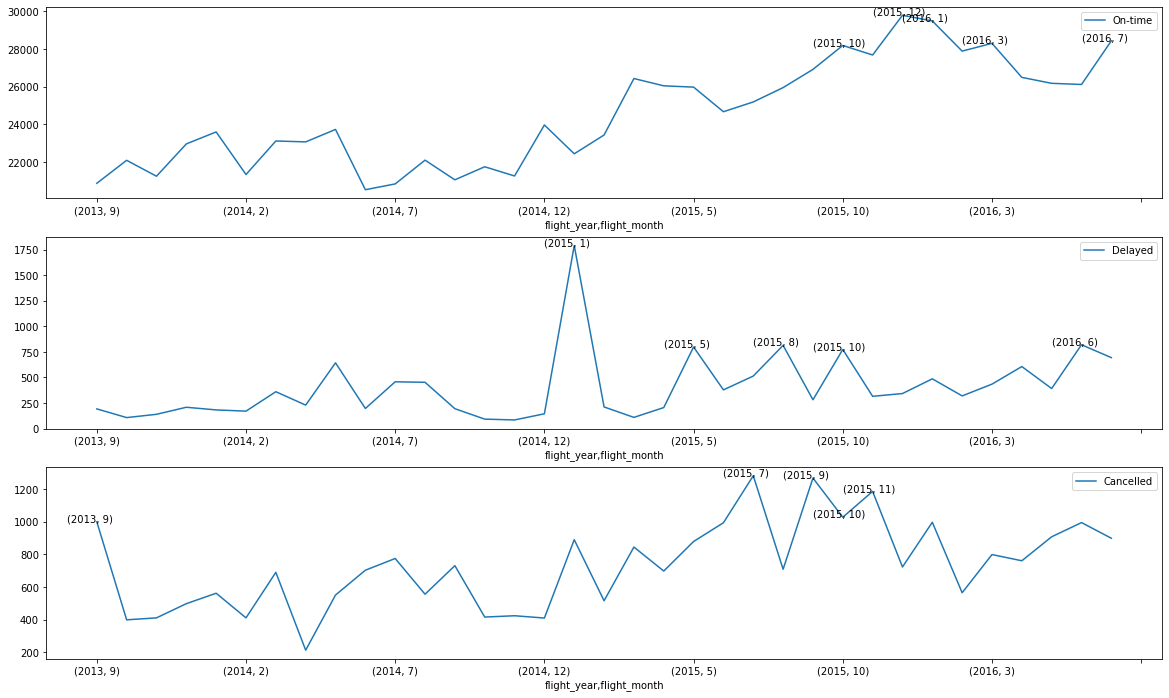

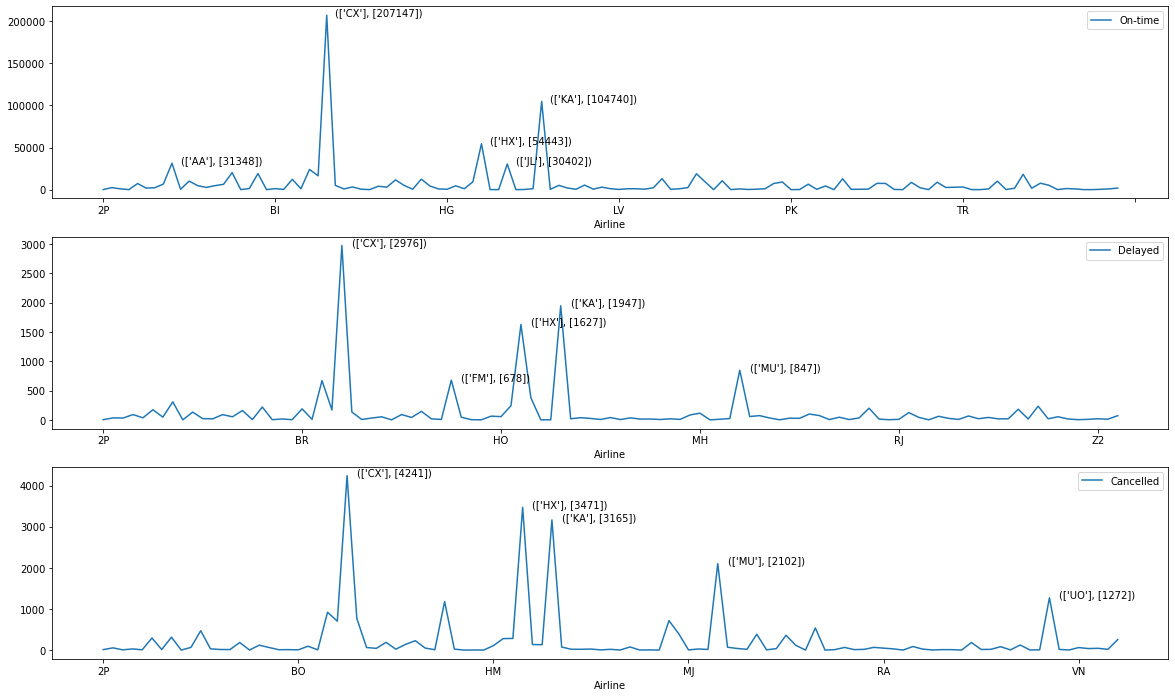

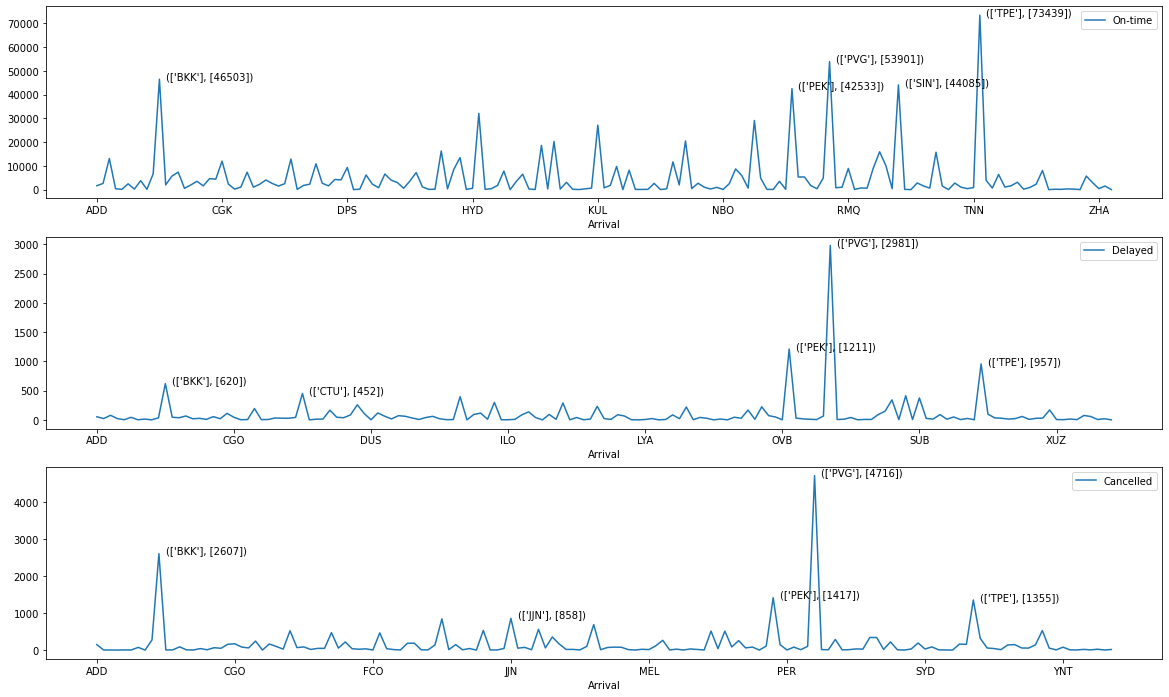

In [14]:

for col in [['flight_year', 'flight_month'], ['Airline'], ['Arrival']]:
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 12))

    count = 0
    for item in dataframe_dict.items():
        value_count_plot(item=item, value_columns=col, axis_index=count)
        count += 1

# EDA Summary
### flight date
    Above figure shows that cancelled and delayed flights happens more on second half year of 2015
    and a massive delayed on Jan. 2015.
    Then we make statistic columns `flight_date_count`, `flight_date_count_delayed`, `flight_date_count_cancelled`, `flight_date_delayed_ratio`
### airline
    There are some specific airlines that has a higher chance of delay and cancel, there is also some airlines that have relatively higher chance of on-time such as `JL`.
    Make statistic columns `airline_count`, `airline_count_delayed`, `airline_count_cancelled`, `airline_delayed_ratio`
### arrival
    We have some arrivals that has a higher chance to delay such as `CTU`
    Make statistic columns `arrival_count`, `arrival_count_delayed`, `arrival_count_cancelled`, `arrival_delayed_ratio`

## Add statistics features to dataframe

In [15]:
def add_statistic_features(dataframe, dataframe_dict, process_col):
    default_col = "delay_time"
    df = dataframe[[process_col, default_col]].groupby(process_col).count().rename(columns={default_col: f"{process_col}_count"})
    for key, val in dataframe_dict.items():
        if key in ["Cancelled", "Delayed"]:
            summary_df = dataframe_dict[key][[process_col, default_col]].groupby([process_col]).count().rename(columns={default_col: f"{process_col}_count"})
            df = df.join(summary_df, how='left', rsuffix=f'_{key.lower()}').fillna(0)
    df[f'{process_col}_delayed_ratio'] = (df[f"{process_col}_count_delayed"] + df[f"{process_col}_count_delayed"]) / df[f"{process_col}_count"]
    dataframe = dataframe.merge(df, left_on=process_col, right_index=True)
    return dataframe
    

In [16]:
for col in ['flight_date', 'Airline', 'Arrival']:
    df = add_statistic_features(df, dataframe_dict, col)
df.head(3)

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,...,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638
283944,883183,UO1844,27,HKG,KIX,UO,14,0.7,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638
529472,1647660,UO1872,27,HKG,KIX,UO,10,0.2,2016-07-01,0,...,13.0,0.025237,19718,234.0,1272.0,0.023735,20913,289.0,355.0,0.027638


In [17]:
df.columns

Index(['flight_id', 'flight_no', 'Week', 'Departure', 'Arrival', 'Airline',
       'std_hour', 'delay_time', 'flight_date', 'is_claim', 'Arrival_enc',
       'Airline_enc', 'flight_year', 'flight_month', 'flight_day', 'label',
       'flight_date_count', 'flight_date_count_delayed',
       'flight_date_count_cancelled', 'flight_date_delayed_ratio',
       'Airline_count', 'Airline_count_delayed', 'Airline_count_cancelled',
       'Airline_delayed_ratio', 'Arrival_count', 'Arrival_count_delayed',
       'Arrival_count_cancelled', 'Arrival_delayed_ratio'],
      dtype='object')

In [18]:
corr = df.corr()
corr.style.background_gradient()

,flight_id,Week,std_hour,delay_time,is_claim,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,label,flight_date_count,flight_date_count_delayed,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
flight_id,1.000000,-0.000464,-0.000312,0.000732,0.000027,0.001506,-0.000990,0.000615,-0.000523,0.000539,0.000027,0.000005,0.000177,-0.000710,0.000143,-0.000091,-0.000318,-0.000339,-0.000426,-0.000242,0.000172,0.000010,-0.001002
Week,-0.000464,1.000000,-0.000044,0.000280,-0.014885,0.000022,0.001193,-0.428646,0.996448,0.096430,-0.014885,-0.175058,-0.099903,-0.011956,-0.101357,0.001404,-0.001725,-0.003025,-0.014753,-0.010123,-0.023693,-0.021936,-0.023012
std_hour,-0.000312,-0.000044,1.000000,0.001467,-0.000237,-0.027307,0.015700,-0.004458,-0.000042,-0.000365,-0.000237,0.000190,-0.001097,-0.000624,-0.001138,-0.099024,-0.095395,-0.089629,0.004921,-0.011915,0.003334,0.009017,-0.031810
delay_time,0.000732,0.000280,0.001467,1.000000,0.801199,0.000331,0.024137,0.015497,0.001396,-0.010313,0.801199,0.017011,0.021108,0.124219,0.020342,-0.024942,-0.007462,0.017009,0.115553,0.019212,0.072292,0.092227,0.081139
is_claim,0.000027,-0.014885,-0.000237,0.801199,1.000000,0.011010,0.018209,0.031114,-0.014830,0.001115,1.000000,0.022983,0.163859,0.125501,0.164204,-0.021949,-0.001565,0.022214,0.137825,0.031755,0.102499,0.113622,0.129343
Arrival_enc,0.001506,0.000022,-0.027307,0.000331,0.011010,1.000000,-0.036466,-0.026731,0.000043,0.000095,0.011010,-0.017722,-0.005054,-0.008007,-0.004308,0.042548,0.069425,0.084796,0.131872,0.369750,0.303862,0.127932,0.169542
Airline_enc,-0.000990,0.001193,0.015700,0.024137,0.018209,-0.036466,1.000000,-0.004919,0.001228,-0.000593,0.018209,-0.002028,-0.000928,-0.001071,-0.000764,-0.368151,-0.342894,-0.280989,-0.033424,-0.030649,-0.041516,-0.014201,-0.026098
flight_year,0.000615,-0.428646,-0.004458,0.015497,0.031114,-0.026731,-0.004919,1.000000,-0.431276,-0.003427,0.031114,0.825432,0.167709,0.238264,0.127139,-0.009914,-0.006592,-0.003141,0.002104,-0.023694,-0.018637,-0.010336,-0.002680
flight_month,-0.000523,0.996448,-0.000042,0.001396,-0.014830,0.000043,0.001228,-0.431276,1.000000,0.014624,-0.014830,-0.179298,-0.105377,-0.003523,-0.107165,0.001312,-0.001863,-0.003196,-0.014971,-0.010307,-0.024017,-0.022304,-0.023234
flight_day,0.000539,0.096430,-0.000365,-0.010313,0.001115,0.000095,-0.000593,-0.003427,0.014624,1.000000,0.001115,0.021028,0.059422,-0.080522,0.065071,0.001141,0.001565,0.001828,0.001887,0.002541,0.003433,0.003757,0.001953


# Preprocessing
1. We will pop columns that we dont need like: `flight_id`, `flight_no`, `Departure`, `Arrival`, `Airline`, `is_claim`, `flight_date`
2. apply stand scale transform on numerical columns

In [19]:
df.pop("flight_id")
df.pop("flight_no")
df.pop("Departure")
df.pop("Arrival")
df.pop("Airline")
df.pop("is_claim")
df.pop("flight_date")
df.pop("delay_time")
label = df.pop("label")
data = df

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
# these are columns that not doing standard scaling
non_std_enc_cols = ["Week", "Arrival_enc", "Airline_enc", "flight_year", "flight_month", "flight_day"]

In [22]:
scaler = StandardScaler()
data[data.columns[~data.columns.isin(non_std_enc_cols)]] = scaler.fit_transform(data[data.columns[~data.columns.isin(non_std_enc_cols)]])

In [23]:
data.head(3)

,Week,std_hour,Arrival_enc,Airline_enc,flight_year,flight_month,flight_day,flight_date_count,flight_date_count_delayed,flight_date_count_cancelled,flight_date_delayed_ratio,Airline_count,Airline_count_delayed,Airline_count_cancelled,Airline_delayed_ratio,Arrival_count,Arrival_count_delayed,Arrival_count_cancelled,Arrival_delayed_ratio
0,27,-0.727183,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729
283944,27,-0.003418,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729
529472,27,-0.727183,73,110,2016,7,1,0.972644,-0.064276,-0.64641,-0.10204,-0.677813,-0.791803,-0.317705,-0.42086,-0.234256,-0.274999,-0.381789,-0.14729


# Feature Selection

## First try
I will train with these normalized features first. If the result cant reach our expectation then we will do EDA and feature selection.
We will do feature selection with sequential feature selection method.

In [24]:
from tpot import TPOTClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

/opt/conda/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [25]:
train_config = {
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.1,
}
def custom_training_pack(data, n_estimators: int=100, max_depth: int=6, learning_rate: float=0.1):
    """
    This function trains a XGBClassifier
    Params:
        data: the training data
        n_estimators: epochs the model to be trained
        max_depth: tree depth of the model
        learning_rate: learning rate of the model
    Returns:
        a dictionary contains two keys: model, report
        {"model": xgb, "report": report}
    """
    len_features = len(data.columns)

    xgb = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        use_label_encoder=False,
                        n_jobs=-1,
                        verbosity=0)

    X_train, X_test, y_train, y_test = train_test_split(data,
                                                        label.values,
                                                        train_size=0.75,
                                                        test_size=0.25,
                                                        random_state=39)

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    classification_report(y_test, y_pred, output_dict=True)
    return {"model": xgb, "report": classification_report(y_test, y_pred, output_dict=True)}

In [26]:
result = custom_training_pack(data, **train_config)
result

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=0),
 'report': {'False': {'precision': 0.9617169425664294,
   'recall': 0.9979582418504482,
   'f1-score': 0.9795024775465198,
   'support': 214521},
  'True': {'precision': 0.7489971346704871,
   'recall': 0.1329738528843219,
   'f1-score': 0.22585104544669085,
   'support': 9829},
  'accuracy': 0.9600624024960999,

In [27]:
data.columns

Index(['Week', 'std_hour', 'Arrival_enc', 'Airline_enc', 'flight_year',
       'flight_month', 'flight_day', 'flight_date_count',
       'flight_date_count_delayed', 'flight_date_count_cancelled',
       'flight_date_delayed_ratio', 'Airline_count', 'Airline_count_delayed',
       'Airline_count_cancelled', 'Airline_delayed_ratio', 'Arrival_count',
       'Arrival_count_delayed', 'Arrival_count_cancelled',
       'Arrival_delayed_ratio'],
      dtype='object')

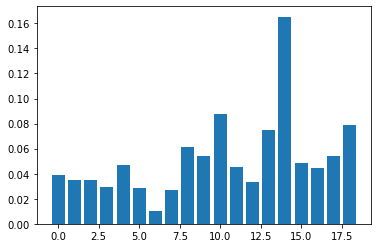

In [28]:
%matplotlib inline
xgb = result["model"]
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [29]:
# !pip install tpot mlxtend scikit-learn joblib xgboost

## SFS
We want to chose the most representative features to take into training. So, we use sequential feature selection method to determine features.
We can see that the overall performance improved, the f1-score goes to 0.9986 to 0.9989 under same training config.

In [30]:
len_features = len(data.columns)

xgb = XGBClassifier(n_estimators=10,
                    max_depth=6,
                    learning_rate=0.1,
                    use_label_encoder=False,
                    n_jobs=-1,
                    verbosity=0)

X_train, _, y_train, _ = train_test_split(data,
                                          label.values,
                                          train_size=0.75,
                                          test_size=0.25,
                                          random_state=39)

In [ ]:
%%time
sfs = SFS(xgb,
          k_features=(1, len_features),
          forward=True,
          # floating=True,
          verbose=1,
          cv=2, # deafault using 5, changing to 2 for less computing time
          n_jobs=-1)
sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  2.1min finished
Features: 1/19[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.2min finished
Features: 2/19[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  2.3min finished
Features: 3/19[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.4min finished
Features: 4/19[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The selected features are shown down below

In [158]:
# selected_features = list(sfs.k_feature_names_)
selected_features = ['Week', 'std_hour', 'delay_time', 'Arrival_enc', 'flight_month', 'flight_day', 'flight_date_count', 'flight_date_count_cancelled', 'flight_date_delayed_ratio', 'Arrival_count_cancelled', 'Arrival_delayed_ratio']
selected_features = ['Week', 'std_hour', 'Arrival_enc', 'flight_month', 'flight_day', 'flight_date_count', 'flight_date_count_cancelled', 'flight_date_delayed_ratio', 'Arrival_count_cancelled', 'Arrival_delayed_ratio']

In [159]:
selected_data = data[selected_features]

In [160]:
result = custom_training_pack(selected_data, **train_config)
result

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=0),
 'report': {'False': {'precision': 0.9607523769781977,
   'recall': 0.9981307191370542,
   'f1-score': 0.9790849314567387,
   'support': 214521},
  'True': {'precision': 0.729602157788267,
   'recall': 0.11008240919727337,
   'f1-score': 0.1913012729844413,
   'support': 9829},
  'accuracy': 0.9592244261199019,


In [128]:
data.columns

Index(['Week', 'std_hour', 'delay_time', 'Arrival_enc', 'Airline_enc',
       'flight_year', 'flight_month', 'flight_day', 'flight_date_count',
       'flight_date_count_delayed', 'flight_date_count_cancelled',
       'flight_date_delayed_ratio', 'Airline_count', 'Airline_count_delayed',
       'Airline_count_cancelled', 'Airline_delayed_ratio', 'Arrival_count',
       'Arrival_count_delayed', 'Arrival_count_cancelled',
       'Arrival_delayed_ratio'],
      dtype='object')

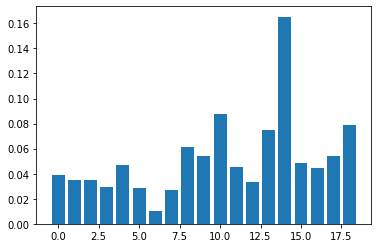

In [129]:
%matplotlib inline
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

# Hyper parameter tunning

In [28]:
import numpy as np

In [29]:
tpot_config = {
    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(3, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [-1],
        'verbosity': [0],
        # 'gpu_id': [0],
        # 'predictor': ['gpu_predictor']
    },
}

In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(selected_data.values,
                                                    label.values,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=77)
tpot_algo = TPOTClassifier(generations=3,
                           population_size=5,
                           scoring='f1',
                           cv=3,
                           n_jobs=-1,
                           random_state=77,
                           early_stop=2,
                           verbosity=2,
                           config_dict=tpot_config)

tpot_algo.fit(X_train, y_train)
X_pre = tpot_algo.predict(X_test)
report_pre = classification_report(y_test, X_pre)

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]

/home/tim/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/tim/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/tim/.local/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/tim/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan


Generation 1 - Current best internal CV score: 0.995771943884371

Generation 2 - Current best internal CV score: 0.995771943884371

Generation 3 - Current best internal CV score: 0.995771943884371

The optimized pipeline was not improved after evaluating 2 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=1.0, max_depth=7, min_child_weight=12, n_estimators=100, n_jobs=-1, subsample=0.3, verbosity=0)
CPU times: user 6min 25s, sys: 1.42 s, total: 6min 26s
Wall time: 20min 41s


In [31]:
model = tpot_algo.fitted_pipeline_

In [32]:
model.named_steps

{'featureunion': FeatureUnion(transformer_list=[('functiontransformer-1',
                                 FunctionTransformer(func=<function copy at 0x7fe459219790>)),
                                ('functiontransformer-2',
                                 FunctionTransformer(func=<function copy at 0x7fe459219790>))]),
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=1.0, max_delta_step=0,
               max_depth=7, min_child_weight=12, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=77,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
               tree_method='exact', validate_parameters=1, verbosity=0)}

In [33]:
tpot_algo.export('tpot_digits_pipeline.py')

In [34]:
%%time
model.named_steps['xgbclassifier'].set_params(n_estimators=1000,
                                              early_stopping_rounds=10)
model.fit(X_train, y_train)

/home/tim/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 24min 59s, sys: 2.2 s, total: 25min 1s
Wall time: 2min 17s


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7fe459219790>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7fe459219790>))])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree...
                               enable_categorical=False, gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=1.0, max_delta_step=0, max_depth=7,
                               min_child_weight=12, missing=nan,
                               monotone_constraints='()', n_estimato

In [35]:
X_predict = model.predict(X_test)
X_predict_pro = model.predict_proba(X_test)

In [36]:
classification_report(y_test, X_predict, output_dict=True)

{'False': {'precision': 0.9998741599008194,
  'recall': 0.9998834803035105,
  'f1-score': 0.9998788200804449,
  'support': 214556},
 'True': {'precision': 0.9974468954248366,
  'recall': 0.9972432101286502,
  'f1-score': 0.9973450423772083,
  'support': 9794},
 'accuracy': 0.9997682193002005,
 'macro avg': {'precision': 0.998660527662828,
  'recall': 0.9985633452160804,
  'f1-score': 0.9986119312288266,
  'support': 224350},
 'weighted avg': {'precision': 0.9997681976620061,
  'recall': 0.9997682193002005,
  'f1-score': 0.9997682080063398,
  'support': 224350}}

# add new column weekday 

## weekday

In [28]:
xgb.feature_importances_

array([2.1856579e-04, 2.8861940e-04, 9.9600160e-01, 3.1737282e-04,
       2.6856488e-04, 0.0000000e+00, 0.0000000e+00, 2.3557759e-04,
       2.3315642e-04, 4.2845501e-04, 2.2834504e-04, 3.5533108e-04,
       2.0739016e-04, 0.0000000e+00, 2.2080085e-04, 2.3298662e-05,
       2.3745091e-04, 2.8005330e-04, 2.6127824e-04, 1.9419771e-04],
      dtype=float32)

In [28]:
xgb.feature_importances_

array([2.1856579e-04, 2.8861940e-04, 9.9600160e-01, 3.1737282e-04,
       2.6856488e-04, 0.0000000e+00, 0.0000000e+00, 2.3557759e-04,
       2.3315642e-04, 4.2845501e-04, 2.2834504e-04, 3.5533108e-04,
       2.0739016e-04, 0.0000000e+00, 2.2080085e-04, 2.3298662e-05,
       2.3745091e-04, 2.8005330e-04, 2.6127824e-04, 1.9419771e-04],
      dtype=float32)